<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/ZiluSu/Synthetic-Training-Data-Generation-for-Co-segmentation/blob/master/synthesis%20evaluation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td></table>

## Mask-RCNN and COCO API



In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip3 uninstall -y keras
!pip3 install keras==2.1.0

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

## Imports

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [6]:
class SegEvaConfig(Config):
  
    NAME = "synthesis_evaluation"
    
    NUM_CLASSES = 1 + 10

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = SegEvaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Real and Synthetic Mixed Data

In [ ]:
!wget https://github.com/ZiluSu/Synthetic-Training-Data-Generation-for-Co-segmentation/raw/master/mixed_data.zip
!unzip mixed_data.zip

In [8]:
class myDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'cat')
        self.add_class('dataset', 2, 'dog')
        self.add_class('dataset', 3, 'horse')
        self.add_class('dataset', 4, 'sheep')
        self.add_class('dataset', 5, 'cow')
        self.add_class('dataset', 6, 'elephant')
        self.add_class('dataset', 7, 'bird')
        self.add_class('dataset', 8, 'bear')
        self.add_class('dataset', 9, 'zebra')
        self.add_class('dataset', 10, 'giraffe')
        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
            
        masks = np.zeros([img_anns['imageHeight'], img_anns['imageWidth'], len(img_anns['shapes'])], dtype='uint8')
        classes = []
        for i, anno in enumerate(img_anns['shapes']):
            mask = np.zeros([img_anns['imageHeight'], img_anns['imageWidth']], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [10]:
# Create training and validation set
# train set
dataset_train = myDataset()
dataset_train.load_dataset('mixed_data/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# test/val set
dataset_val = myDataset()
dataset_val.load_dataset('mixed_data/test')
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

Train: 1214
Test: 50


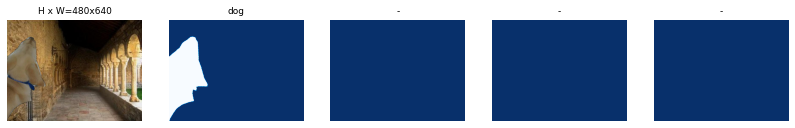

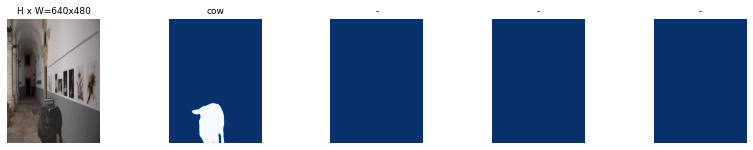

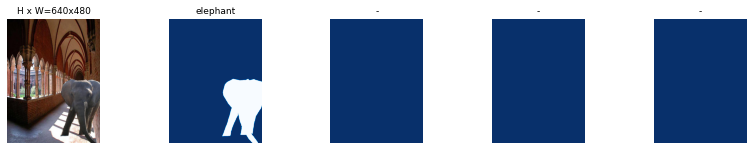

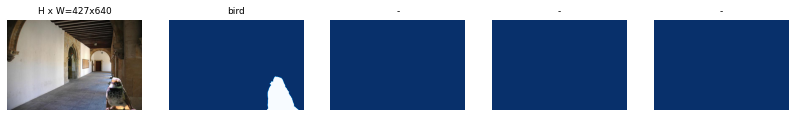

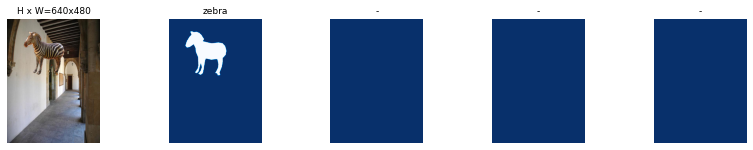

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
init_with = "coco"  # imagenet, coco

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head layers
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/synthesis_evaluation20201120T1347/mask_rcnn_synthesis_evaluation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribu

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 999/1000 [============================>.] - ETA: 1s - loss: 0.6787 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1546 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.1552

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1000/1000 [==============================] - 1257s 1s/step - loss: 0.6783 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.1552 - val_loss: 0.5558 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.1039 - val_mrcnn_class_loss: 0.0472 - val_mrcnn_bbox_loss: 0.2280 - val_mrcnn_mask_loss: 0.1712
Epoch 2/5
1000/1000 [==============================] - 1178s 1s/step - loss: 0.3994 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1077 - val_loss: 0.5666 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.1784 - val_mrcnn_class_loss: 0.0388 - val_mrcnn_bbox_loss: 0.1864 - val_mrcnn_mask_loss: 0.1600
Epoch 3/5
1000/1000 [==============================] - 1176s 1s/step - loss: 0.3600 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1012 - val_loss: 0.4671 - val_rpn_class_loss

## Inference

In [ ]:
class InferenceConfig(SegEvaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [16]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    8.00000  max:    8.00000  int32
gt_bbox                  shape: (1, 4)                min:  232.00000  max:  566.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


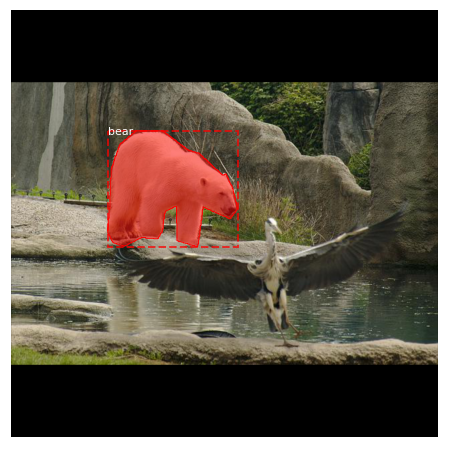

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


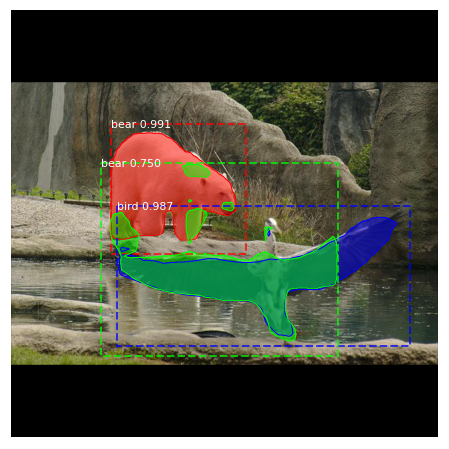

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on testing data
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8178571428571427


###### Reference: 
https://github.com/TannerGilbert/MaskRCNN-Object-Detection-and-Segmentation/blob/master/MaskRCNN%20Microcontroller%20Segmentation.ipynb